In [141]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from IPython.display import clear_output, display

This is the start of our EECE 699 Assignment. After completing the pre-lab, I am now familiar with the SHAP library and ready to apply it on a real life example. I chose the IMDB Reviews Dataset because I am accustomed to this dataset having worked on it before. Also, its structure is clear and the work prior to the SHAP library should be straightforward, which will give us more time to focus on the part including the interpretability of the model.

We will start by reading the CSV, fixing the data in the format we want, and cleaning the data a little bit to potentially improve the accuracy of our model. More work could could have been done when it comes to data handling like lemmatization for example, but this isn't really necessary in our case since we can use a simple model, and doing so won't deeply affect our perfomance (after trying to implement it, and decided to discard after taking a lot of time to run).

## Preparation

In [170]:
%%capture
!pip install shap
import shap

In [171]:
df = pd.read_csv("/content/drive/MyDrive/EECE 699/IMDB.csv")

In [172]:
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [173]:
class_names = df["sentiment"].unique()
class_names

array(['positive', 'negative'], dtype=object)

We can see that we only have 2 possible values. We will implement a funcion to handle that accordingly. I decided to implement it manually instead of using an existing function in sklearn.

In [174]:
def sentiment_to_bits(x):
  if x=="positive":
    return 1
  else:
    return 0

In [175]:
df["sentiment"] = df["sentiment"].apply(lambda x: sentiment_to_bits(x))

In [176]:
df.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

We can see that we now have 1 and 0 instead of positive and negative, and that is what we wanted in order to feed it to our model. We will now use the cleaning function taken from a NLP project I had previously worked on, and use it on our model.

In [177]:
def clean(df, text_field):
    df[text_field] = df[text_field].str.replace(r"\n", "")
    df[text_field] = df[text_field].str.replace(r"<br />", "")
    df[text_field] = df[text_field].str.replace(r"<br>", "")
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z]+",' ')
    df[text_field] = df[text_field].str.lower()
    return df
   
df = standardize_text(df, "review")

In [178]:
df.head()

review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production br br the filmin...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically there s a family where a little boy ...          0
4  petter mattei s love in the time of money is a...          1

We can see that special character were removed and some other potentially bad input like < br />.  We will run a last function to check some general info about the df.

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Everything seems fine here with no null values. We will proceed to the model. 

## Model

We will start by splitting our data into training and testing data with a 80% split.
After doing so, we will initialize a vectorizer, and we chose the TfidfVectorizer instead of the CountVectorizer. We might decide to change based on the results. We fit it on X_train and run it on both X_train and X_test.

In [180]:
X = df["review"].values
y = df["sentiment"].values
X_train_origin, X_test_origin, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_origin)
X_test = vectorizer.transform(X_test_origin)

We run a Logistic Regression model, and the reason for that is that I adopted the following approach: we start by the simplest model and see how it performs. If it performs well enough, we will stop and proceed. Else, we try hyperparameter optimization or a whole new model. 
We will start with a basic logistic regression with C=1, a penalty of l1 and a 'liblinear' solver.

In [181]:
model = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [182]:
y_test = y_test.reshape(-1,1)
y_pred = model.predict(X_test)

In [183]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.885, precision = 0.876, recall = 0.897, f1 = 0.887


In [184]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      5007
           1       0.88      0.90      0.89      4993

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Seeing the result, all validation metrics are scoring 87% and higher, which is well enough an NLP application of this level. I considered it enough and proceeded accordingly. 

## SHAP

We define a shap explainer instance using the model and the X_train data. We also initialize the shap_values using the testing data and the explainer. We then cast them into arrays.

In [185]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test[:50])
X_test_array = X_test[:50].toarray() 

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


The summary plot gives an overview about some word encountered in the selected testing data. We can see how bad, worst, annoying and such words are generally included in instances of low SHAP value, which shows that they have a negative impact on the review. Also, the colors of each data points show how much value it has on the input. 

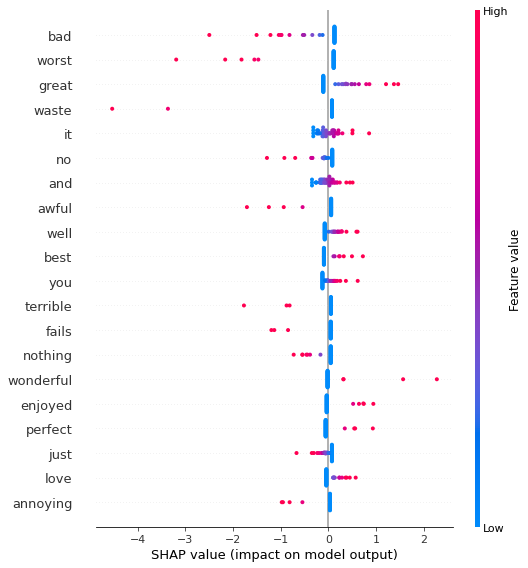

In [59]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

We will now start looking at specific  testing instances and visualize them.

### 1st Example


We will start by looking at a positive review.

In [67]:
ind = 5

print("Positive" if y_test[ind] else "Negative", "Review")

Positive Review


We showcase the review in the following cell:

In [66]:
clear_output(wait=True)
X_test_origin[ind]

'the weakness of this comes from the confusing storytelling plots often coming out of nowhere but it really didn t matter because i still enjoyed it to it s full length once you actually accept that this movies not to be taken too seriously then you ll enjoy it even more it s basically a love story a confusing one at first but as it evolves it really is something worthwhile sure it s been done so many times before but the complicated version of this is quite inspiring and touching br br the over the top fantasy and cgi was overwhelming at first but i still enjoyed its purpose and people quit whining about how it borrowed from other movies guess what we know and it doesn t really matter because its purpose was to humour and entertain sometimes people has to stop being so critical and think for a moment before they start yapping about comparing this to hollywood standards is utterly stupid and ignorant it s a totally different style and target audience as far as i m concerned some the be

We will now plot the shap explanations for the testing instance using the force plot and the waterfall plots. Looking at the documentation, we write the code for the visualizations and look to analyze.

In [64]:
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

From the force plot, we can see how the words affect our output. Lots of words are affecting the shap value and the output positively like touching and enjoyed. Some other words like stupid and basically are affecting in the negative direction. However it is clear that the positive words are more and have more weight which caused this result to be positive. The results are consistent with the logic of reading the interview as we can sense the positive tone. We assert the following in the waterfall plot.

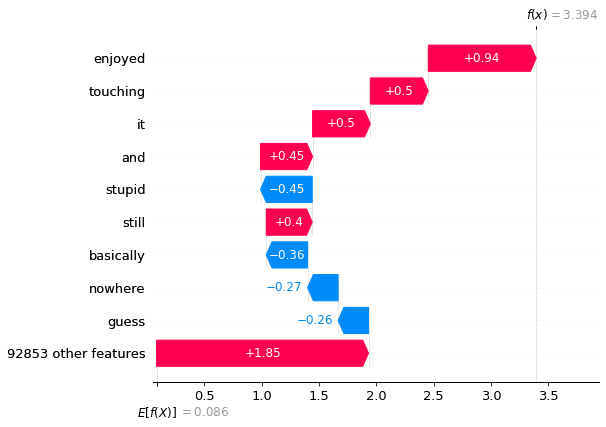

In [26]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[ind], feature_names=vectorizer.get_feature_names())

### 2nd Example


We now look at a neutral review, by adopting the same procedure as above. While reading we might feel it's positive, but when it comes to words, they are distributed between positive and negative.

In [68]:
ind = 10

print("Positive" if y_test[ind] else "Negative", "Review")

Negative Review


In [69]:
clear_output(wait=True)
X_test_origin[ind]

'i honestly thought this movie was going to be cheesy even though i ve liked alvin and the chipmunks for a long time i was was very wrong it was great it has been the best movie i have seen since october in my opinion it s the movie everyone should see this holiday season enchanted i thought anyway was awful the golden compass was alright but the ending was pretty crappy to his dark materials fans and i am legend well i haven t seen that yet or national treasures but it looks alright br br i m not about to give anything away but this movie is great for anyone especially kids '

In [70]:
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

We can see the effect of both end of the spectrum of positive and negative words. Overall, the output of SHAP is negative which doesn't really seem consistent with the logic of reading the review. However, it is explained and mainly because of the use of "big" negative words like awful, crappy ... which pushed the output in this directly. For more insights, we look at the waterfall plot.

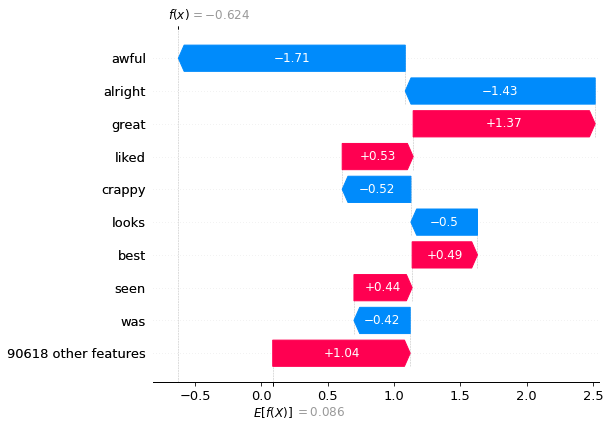

In [71]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[ind], feature_names=vectorizer.get_feature_names())

This seems to make more sense, even though E(f(x)) is still very low and not really significant. We can also see the effect of waful, crappy on the negative side but the also the big effect of positive words like great and liked.

### 3rd Example


We now choose a really negative review here.

In [158]:
ind = 31

print("Positive" if y_test[ind] else "Negative", "Review")

Negative Review


The printed review:

In [159]:
clear_output(wait=True)
X_test_origin[ind]

'i absolutely hate this programme what kind of people sit and watch this garbage ok my dad and mum love it lol but i make sure i m well out of the room before it comes on its so depressing and dreary but the worst thing about it is the acting i cant stand all detective programmes such as this because the detectives are so wooden and heartless what happened to detective programmes with real mystery i mean who wants to know what happened to fictional characters we know nothing about that died over years ago i wish the bbc would put more comedy on bbc cos now with the vicar of dibley finished there is more room for crap like this '

In [84]:
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

We can read the review and see how negative it is and we can see the force plot with f(x)=-3.5 which is a relatively big value (absolute value) and a negative one. This is showcased by tge use of words like worst, nothing, crap, garbage which are awfully negative and explains the solid choice of the model. We will assert this observation with the waterfall plot.

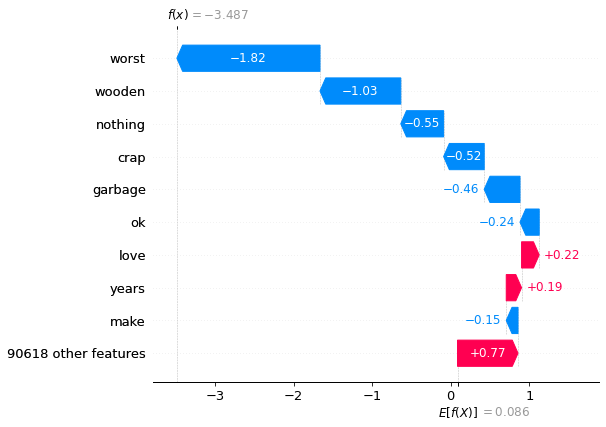

In [85]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[ind], feature_names=vectorizer.get_feature_names())

Again, we can see the consistency here of how negative the review is. More significant features are to the negative side with worst, wooden (which doesn't really seem to make sense), nothing and crap leading the way. Positive words like love are scarce and don't really affect the prediction.

### 4th Example


We will now a work on a personal example. I wrote an example on my favorite movie which I rewatched last week, which is Inception. Being my favorite, my review is obviously positive.

In [186]:
personal_positive_review_string = "I watched Inception last week, the least that could be said is that the movie was amazing. First, the actors were terrific of the likes of Leonardo Di Caprio, Ellen Page, Cillian Murphy amongst other. Also the plot was really good and is sasfying to watch, especially when all makes sense at the end of the movie. The only downside would be that the last few scenes have a few complicated dreams that are hard to understand. Amazing!"

We need to transform the data in a format understandable by the model like we did for the training and testing data. We will use the vectorizer that is already trained on the bulk of our data which is the training data.

In [187]:
personal_positive_review = vectorizer.transform([personal_positive_review_string])

In [188]:
shap_values = explainer.shap_values(personal_positive_review)
X_test_array = personal_positive_review.toarray() 

In [189]:
clear_output(wait=True)
personal_positive_review_string

'I watched Inception last week, the least that could be said is that the movie was amazing. First, the actors were terrific of the likes of Leonardo Di Caprio, Ellen Page, Cillian Murphy amongst other. Also the plot was really good and is sasfying to watch, especially when all makes sense at the end of the movie. The only downside would be that the last few scenes have a few complicated dreams that are hard to understand. Amazing!'

In [190]:
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values, X_test_array,
    feature_names=vectorizer.get_feature_names()
)

As expected, the force plot shows how positive the review is with the highlight on terrific and amazing, having a big effect on the output. The negative words are minimal like least which doesn't really have an effect. This is asserted in the waterfall model.

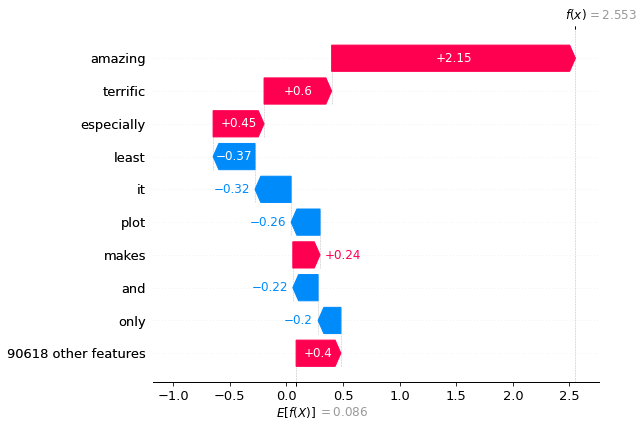

In [112]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=vectorizer.get_feature_names())

### 5th Example


We will do the same for a negative review with White House Down, since I am not really a fan of (intense) action movies.

In [113]:
personal_negative_review_string = "Last week, I watched White House Down, which was a disaster to watch. Nothing happening was logical and all what I saw couldn't ever happen and is impossible. The actors were more like stunt artrists and no art was shown. Horrifying ending and overall a really bad movie."

In [191]:
personal_negative_review = vectorizer.transform([personal_negative_review_string])

In [192]:
shap_values = explainer.shap_values(personal_negative_review)
X_test_array = personal_negative_review.toarray() 

In [193]:
clear_output(wait=True)
personal_negative_review_string

"Last week, I watched White House Down, which was a disaster to watch. Nothing happening was logical and all what I saw couldn't ever happen and is impossible. The actors were more like stunt artrists and no art was shown. Horrifying ending and overall a really bad movie."

In [194]:
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values, X_test_array,
    feature_names=vectorizer.get_feature_names()
)

A big negative value for a very negative review. Words like bad, nothing and disaster lead the way for most affecting features. The same is seen for the waterfall plot. One observation here is that there are some words like was, and, no are considered to be positive or negative which doesn't seem to make sense. One solution would be removing stopwords since they are randomly affecting the model.

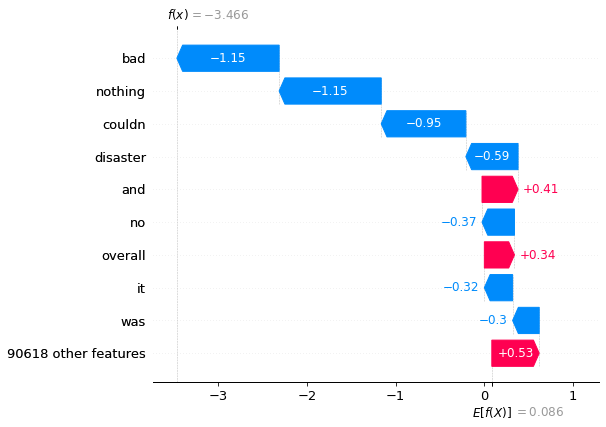

In [118]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=vectorizer.get_feature_names())

## Saving the model and vectorizer

In [197]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))